(Click on the below links to navigate to different sections of the notebook)
# **Overview**  
- <a href="#1"> 1. Importing Data</a>
- <a href="#2"> 2. Preprocessing the Dataset</a>
- <a href="#3"> 3. Explanatory Data Analysis </a>
- <a href="#4"> 4. Divide the data into training and testing data </a>
- <a href="#5"> 5. Model</a>


In [263]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error 

import seaborn as sns

import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## <a id="1"> 1. Importing Data </a>

In [264]:
df2 = pd.read_csv('OLX_Car_Data_CSV.csv',encoding= 'latin1')
df2 = df2.sample(frac=1).reset_index(drop=True)# shuffle
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 24973 rows and 9 columns


In [265]:
display(df2.head(5))
df2.columns

,Brand,Condition,Fuel,KMs Driven,Model,Price,Registered City,Transaction Type,Year
0,Daihatsu,Used,CNG,100000.0,Charade,150000,Karachi,Cash,1984.0
1,Suzuki,Used,CNG,20000.0,Bolan,410000,Karachi,Cash,2004.0
2,Toyota,Used,Hybrid,61000.0,Aqua,1650000,Karachi,Cash,2014.0
3,Toyota,Used,Petrol,92000.0,Camry,1350000,Karachi,Cash,2003.0
4,NaN,NaN,NaN,NaN,NaN,158000,NaN,NaN,NaN


Index(['Brand', 'Condition', 'Fuel', 'KMs Driven', 'Model', 'Price',
       'Registered City', 'Transaction Type', 'Year'],
      dtype='object')

## <a id="2" > 2. Preprocessing the Dataset</a>

### <a id="2-1" > 2.1 Check for NULLS</a>

In [266]:
df2.isnull().sum(axis = 0)

Brand               2137
Condition           2136
Fuel                2445
KMs Driven          2286
Model               2448
Price                  0
Registered City     4636
Transaction Type    2445
Year                2284
dtype: int64

There are too many missing values in the dataset. So instead of removing them <br>we will fill it median, average or most frequent
data.<br>
We will consider "NaN" as some data point. So let's replace it with word "unknown" <br>to treat it as a categorical 
value in its respective columns.

**Replacing "NaN" with "unknown" to treat it as a categorical values in their respective columns**

In [267]:
df2['Brand'].fillna(value='unknown', inplace=True)
df2['Condition'].fillna(value='unknown', inplace=True)
df2['Fuel'].fillna(value='unknown', inplace=True)
df2['Model'].fillna(value='unknown', inplace=True)
df2['Registered City'].fillna(value='unknown', inplace=True)
df2['Transaction Type'].fillna(value='unknown', inplace=True)

In [268]:
df2.isnull().sum(axis = 0)

Brand                  0
Condition              0
Fuel                   0
KMs Driven          2286
Model                  0
Price                  0
Registered City        0
Transaction Type       0
Year                2284
dtype: int64

Let's now fill the missing values in the column "KMs Driven" with average values.

#### Filling the missing data

In [269]:
df2['KMs Driven'].fillna((df2['KMs Driven'].mean()),inplace = True) #average data 
# df2['Year'].fillna(df2['Year'].value_counts().index[0],inplace = True) #most frequent data


In [270]:
df2.isnull().sum(axis = 0)

Brand                  0
Condition              0
Fuel                   0
KMs Driven             0
Model                  0
Price                  0
Registered City        0
Transaction Type       0
Year                2284
dtype: int64

In [271]:
df2=df2.dropna() #drop rows with atleast a column with missing values
df2.isnull().sum(axis = 0)

Brand               0
Condition           0
Fuel                0
KMs Driven          0
Model               0
Price               0
Registered City     0
Transaction Type    0
Year                0
dtype: int64

In [272]:
df2.shape

(22689, 9)

### <a id="2-2" > 2.2 Check the datatype of columns</a>

In [273]:
df2.dtypes

Brand                object
Condition            object
Fuel                 object
KMs Driven          float64
Model                object
Price                 int64
Registered City      object
Transaction Type     object
Year                float64
dtype: object

In [274]:
df2.describe()

,KMs Driven,Price,Year
count,2.268900e+04,2.268900e+04,22689.000000
mean,1.278112e+05,9.212113e+05,2005.901626
std,5.996462e+05,1.593948e+06,9.563804
min,1.000000e+00,5.000000e+04,1915.000000
25%,1.600000e+04,3.800000e+05,2002.000000
50%,6.659200e+04,6.550000e+05,2008.000000
75%,1.000000e+05,1.150000e+06,2013.000000
max,1.000000e+07,8.765432e+07,2020.000000


### <a id="2-3" > 2.3 Remove Outliers</a>

#### Distribution of "Price"

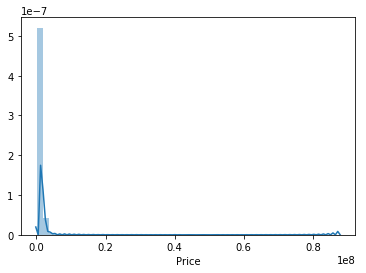

In [275]:

sns.distplot(df2["Price"])

#### Distribution of "KMs Driven"

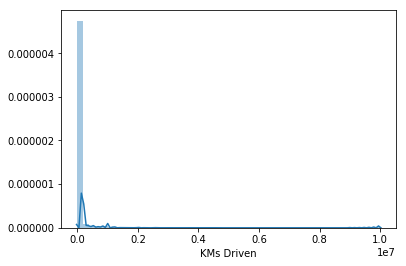

In [276]:
sns.distplot(df2["KMs Driven"])

#### Distribution of "Year"

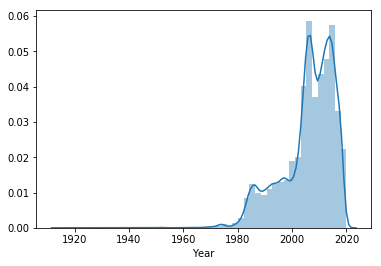

In [277]:
sns.distplot(df2["Year"])

Determine outliers in dataset

In [278]:
cols=['Price']


for i in cols:
    quartile_1,quartile_3 = np.percentile(df2[i],[25,75])
    quartile_f,quartile_l = np.percentile(df2[i],[1,99])
    IQR = quartile_3-quartile_1
    lower_bound = quartile_1 - (1.5*IQR)
    upper_bound = quartile_3 + (1.5*IQR)
    print(i,lower_bound,upper_bound,quartile_f,quartile_l)

    df2[i].loc[df2[i] < lower_bound] = quartile_f
    df2[i].loc[df2[i] > upper_bound] = quartile_l


Price -775000.0 2305000.0 95000.0 4536799.999999985


In [279]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

df2=remove_outlier(df2, 'Price')
# df2=remove_outlier(df2, 'KMs Driven')
# df2=remove_outlier(df2, 'Year')

#### After removing outlier in 'Price'

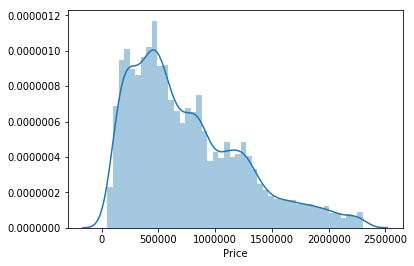

In [280]:
sns.distplot(df2["Price"])

#### After removing outlier in 'KMs Driven'

In [281]:
# sns.distplot(df2["KMs Driven"])

#### After removing outlier in 'Year'

In [282]:
# sns.distplot(df2["Year"])

## <a id="3">3. Explanatory Data Analysis </a>

### <a id="3-1" > 3.1 Distribution of "KMs Driven", "Price", "Year" <a>

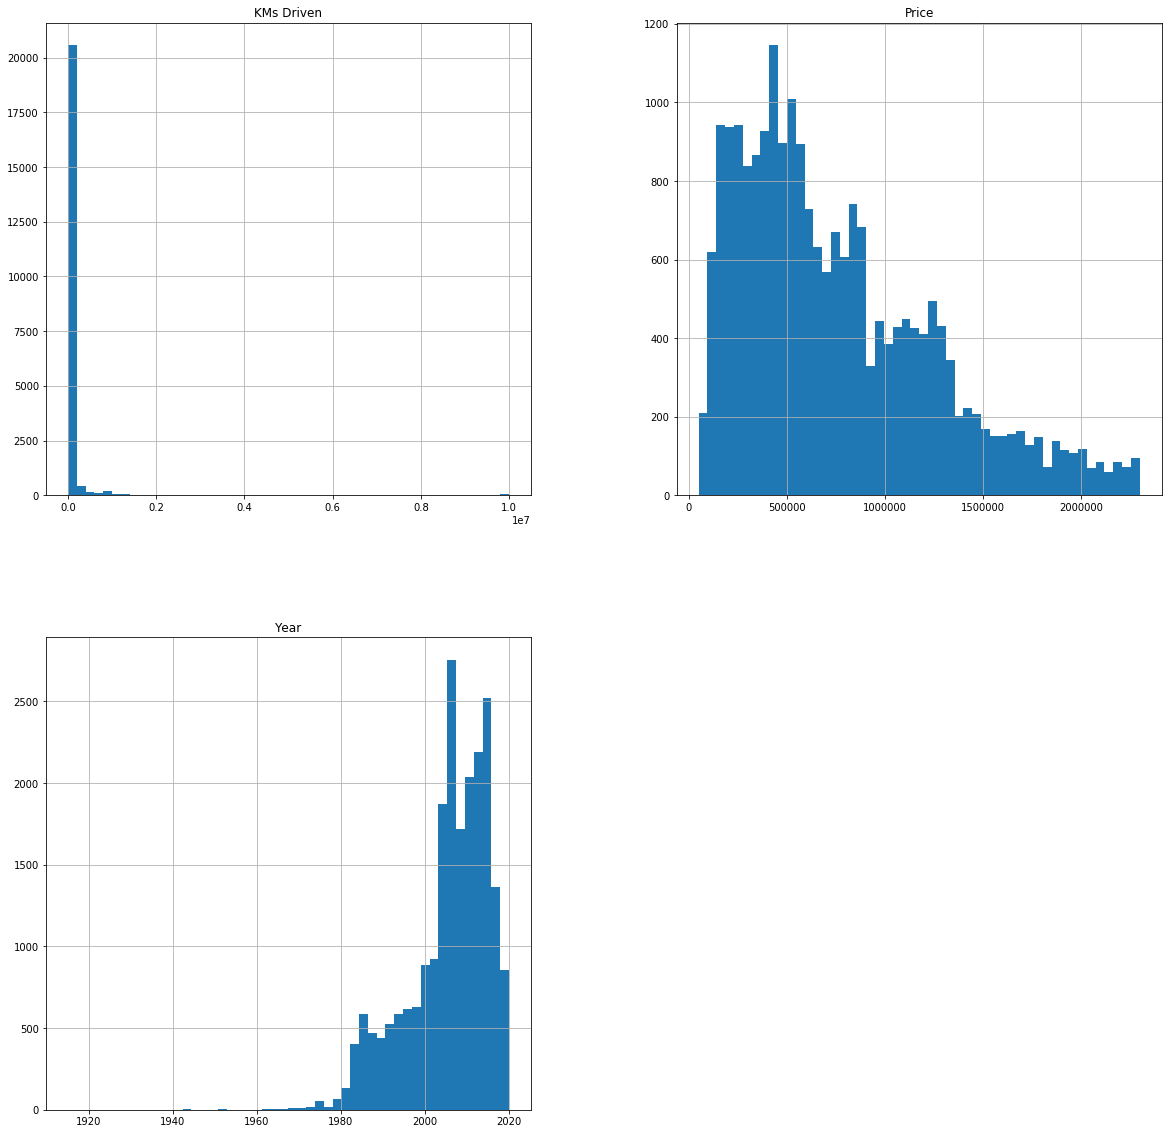

In [283]:
df2.hist(bins = 50 , figsize = (20,20))
plt.show()

### <a id="3-2" > 3.2 Pairplot of different features with "Price"</a>

Pairplot to visualize the realtionship between the target and independent features

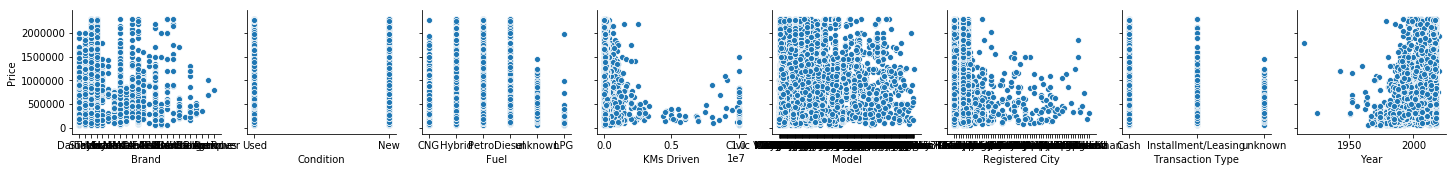

In [284]:

sns.pairplot(df2, x_vars=['Brand', 'Condition', 'Fuel', 'KMs Driven', 'Model',
       'Registered City', 'Transaction Type', 'Year'], y_vars=["Price"],aspect=1);


It can be observed that there is some linear relationship (rougly) between dependent variable "Price"
and independent variables "Brand", "KMs Driven", "Registered City" and "Year" .

So let's draw these plots separately for clear view.

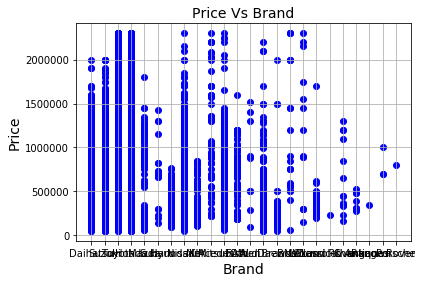

In [285]:
plt.scatter(df2['Brand'], df2['Price'], color='blue')
plt.title('Price Vs Brand', fontsize=14)
plt.xlabel('Brand', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

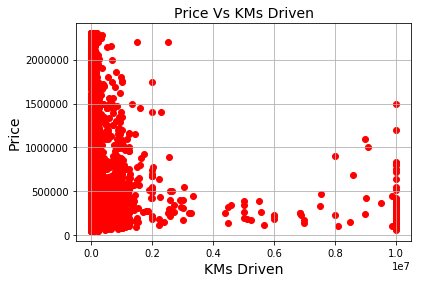

In [286]:
plt.scatter(df2['KMs Driven'], df2['Price'], color='red')
plt.title('Price Vs KMs Driven', fontsize=14)
plt.xlabel('KMs Driven', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()
 


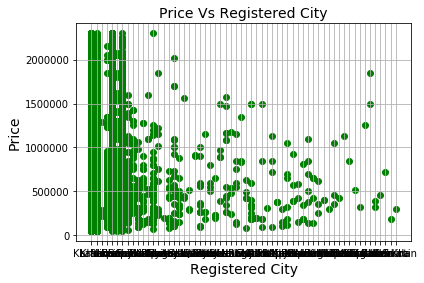

In [287]:
plt.scatter(df2['Registered City'], df2['Price'], color='green')
plt.title('Price Vs Registered City', fontsize=14)
plt.xlabel('Registered City', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

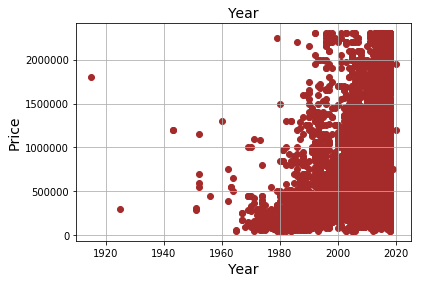

In [288]:
plt.scatter(df2['Year'], df2['Price'], color='brown')
plt.title('Year', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

### <a id="3-2" > 3.2 Encoding the categorical data (one hot Encoding)</a>

In [289]:
# df2=df2.drop(['Transaction Type','Model'], axis=1)

In [290]:
df3=pd.get_dummies(df2,drop_first=True)
df3.head()

,KMs Driven,Price,Year,Brand_BMW,Brand_Changan,Brand_Chevrolet,Brand_Classic & Antiques,Brand_Daewoo,Brand_Daihatsu,Brand_FAW,...,Registered City_Sialkot,Registered City_Sukkar,Registered City_Sukkur,Registered City_Swabi,Registered City_Tank,Registered City_Vehari,Registered City_Wah,Registered City_unknown,Transaction Type_Installment/Leasing,Transaction Type_unknown
0,100000.0,150000.0,1984.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,20000.0,410000.0,2004.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,61000.0,1650000.0,2014.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,92000.0,1350000.0,2003.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,60200.0,925000.0,2011.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## <a id="4"> 4.  Divide the data into training and testing data </a>

In [291]:
df_y = df3['Price'].values
df_X = df3.drop(['Price'], axis=1)


In [292]:
test_size = 0.30

#Split into train and validation
X_train, X_test, Y_train, Y_test = train_test_split(df_X,df_y, test_size=test_size,shuffle=True, random_state = 3)


In [293]:
# #Now I will keep 10% of training data for validation
# validation_size = 0.10

# #Split into train and validation
# X_train, X_val, Y_train, Y_val = train_test_split(X_train1,Y_train1, test_size=validation_size,shuffle=True, random_state = 4)


## <a id="5"> 5. Model</a>

## Random forest Regressor

In [294]:
rf = RandomForestRegressor()

param_grid = { "criterion" : ["mse"]
              , "min_samples_leaf" : [3]
              , "min_samples_split" : [3]
              , "max_depth": [10]
              , "n_estimators": [500]}

### Grid searching of hyperparameters

In [295]:
gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
gs = gs.fit(X_train, Y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.9s finished


In [296]:
print(gs.best_score_)
print(gs.best_params_)
 

0.8443931233150793
{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 500}


In [297]:
bp = gs.best_params_
rf_regressor = RandomForestRegressor(criterion=bp['criterion'],
                              min_samples_leaf=bp['min_samples_leaf'],
                              min_samples_split=bp['min_samples_split'],
                              max_depth=bp['max_depth'],
                              n_estimators=bp['n_estimators'])
rf_regressor.fit(X_train, Y_train)

print("Train R^2 Score:")
print('Score: %.2f' % rf_regressor.score(X_train, Y_train))


Train R^2 Score:
Score: 0.88


### K Fold cross validation

Now we will do cross validation . This is because we split dataset in train and test. It may happen that test and train does not have uniform distribution of samples. So to make sure our model doesn't overfit i.e to generalize it we will do cross validation.

In [298]:
#Predicting the Price using cross validation (KFold method)
y_pred_rf = cross_val_predict(rf_regressor, X_train, Y_train, cv=10 )

#Random Forest Regression Accuracy with cross validation
accuracy_rf = metrics.r2_score(Y_train, y_pred_rf)
print('Cross-Predicted(KFold) Random Forest Regression Accuracy: %.2f '% accuracy_rf)

Cross-Predicted(KFold) Random Forest Regression Accuracy: 0.85 


In [299]:
print("Test R^2 Score:")
print('Score: %.2f' % rf_regressor.score(X_test, Y_test))

Test R^2 Score:
Score: 0.85


Let's find what features are most important

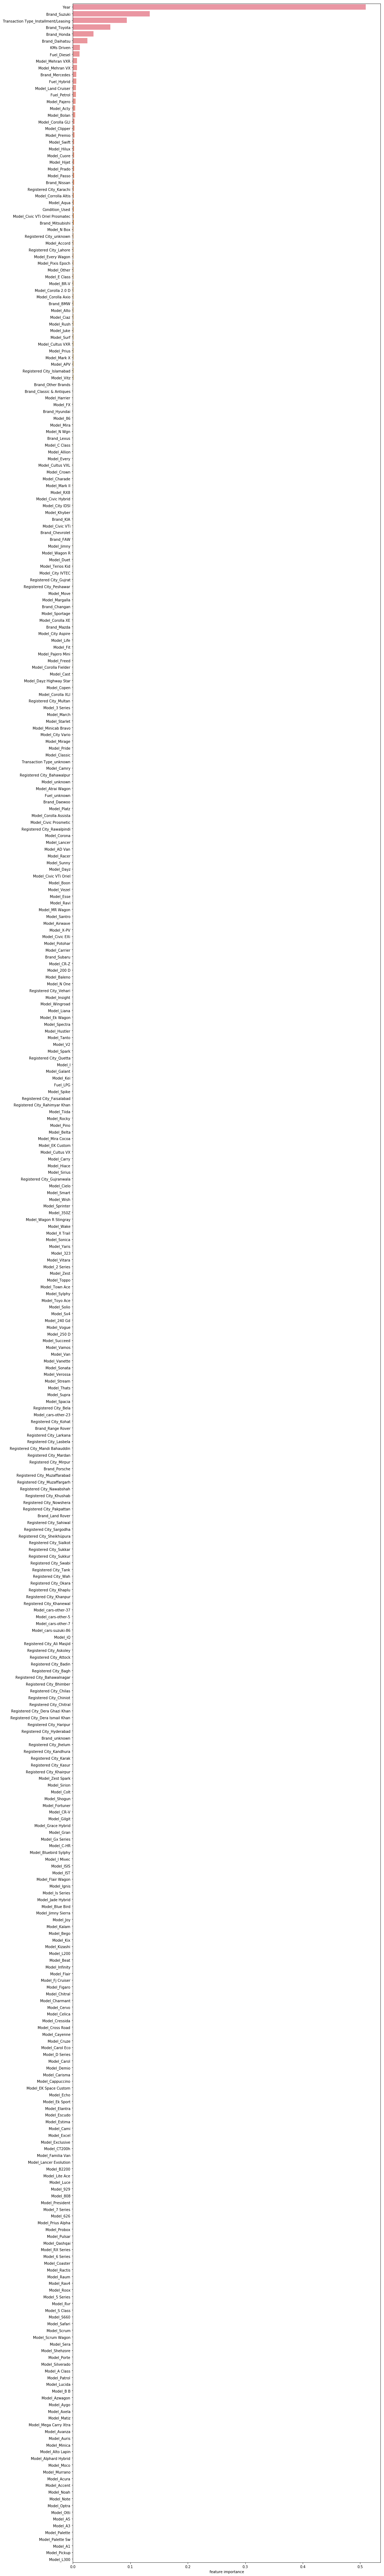

In [300]:
ranking = np.argsort(-rf_regressor.feature_importances_)
f, ax = plt.subplots(figsize=(15, 100))
sns.barplot(x=rf_regressor.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

I am going to keep 30 most dominant features

In [301]:

X_train = X_train.iloc[:,ranking[:30]]
X_test = X_test.iloc[:,ranking[:30]]


### Correlation Matrix

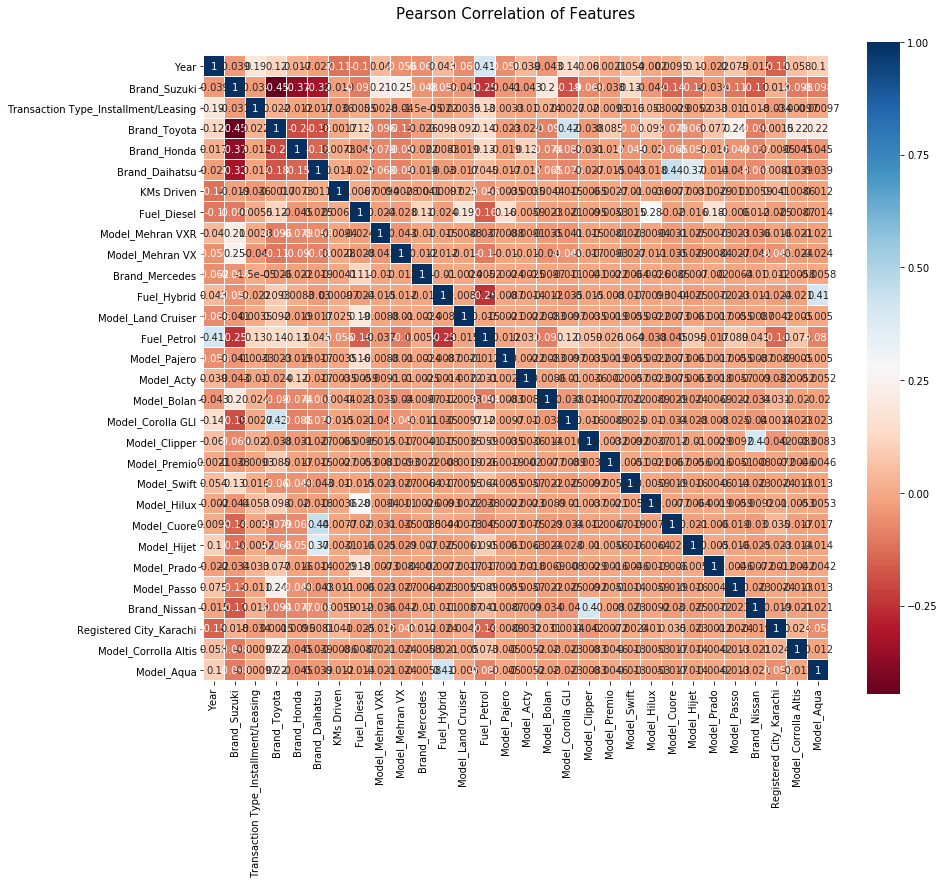

In [302]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into our learning model because this means that there isn't much redundant or superfluous data in our training set. Here are two most correlated features are that of "Brand_Toyata" and "Model_Corolla_GLI".

Let's run the Linear Regression to check if removing the less dominant features improved the model from earlier version.

## Linear Regression

In [303]:
regr = LinearRegression()

regr.fit(X_train, Y_train)

y_pred = regr.predict(X_test)

In [304]:
print('Train R^2 \nscore: %.2f' % regr.score(X_train, Y_train))

Train R^2 
score: 0.75


In [305]:
print('Test R^2 \nscore: %.2f' % regr.score(X_test, Y_test))


Test R^2 
score: 0.73


#### K-Fold Cross Validation

In [306]:
#Predicting the Price using cross validation (KFold method)
y_pred_kf = cross_val_predict(regr, X_train, Y_train, cv=10 )

#Accuracy with cross validation (KFold method)
accuracy_lf = metrics.r2_score(Y_train, y_pred_kf)
print('Cross-Predicted(KFold) Mutiple Linear Regression Accuracy: %.2f' % accuracy_lf)


Cross-Predicted(KFold) Mutiple Linear Regression Accuracy: 0.75


In [307]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, y_pred))

print('Intercept: \n', regr.intercept_)

# The coefficients
print('Coefficients: \n', regr.coef_)


 

Mean squared error: 66508083160.84
Intercept: 
 -57856452.873401344
Coefficients: 
 [ 2.91694470e+04 -6.82217018e+04 -7.03885108e+05  3.73051514e+05
  2.89814601e+05  1.24107971e+05 -8.95660662e-03  2.37578485e+05
 -2.18143612e+05 -1.76800294e+05  7.53077681e+05  2.12378909e+05
  6.44550526e+05  1.16250425e+05  6.91588496e+05 -4.75050906e+05
 -2.35323320e+04  2.25871331e+05 -3.00916635e+05  4.52756602e+05
  2.10376304e+05  3.14944444e+05 -2.80692593e+05 -2.20049730e+05
  8.65133221e+05 -1.16256595e+05  1.60099436e+05 -5.89868447e+04
  2.62204619e+05  4.56450889e+05]


### Scatter Plot of Predicted Price Vs Actual Price

Text(0,0.5,'Predictions')

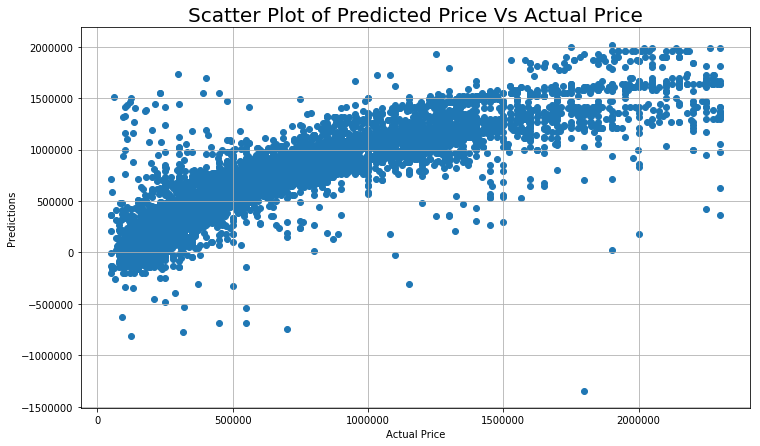

In [308]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.title('Scatter Plot of Predicted Price Vs Actual Price', y=1, size=20)
plt.scatter(Y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predictions")

### Residual Plot

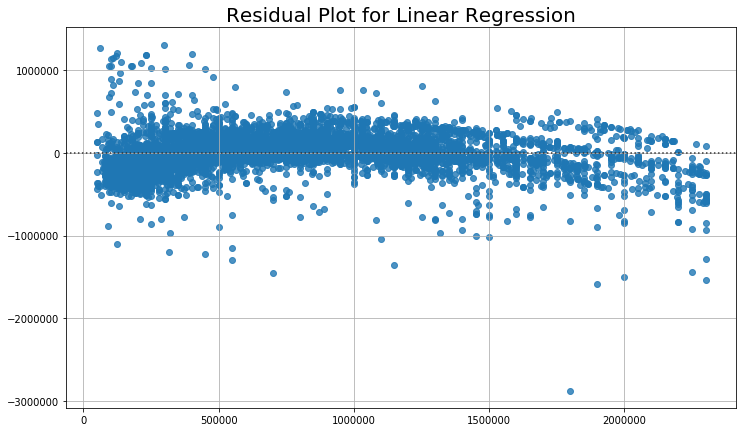

In [309]:
plt.figure(figsize=(12,7)) 
plt.grid(True)
plt.title('Residual Plot for Linear Regression', y=1, size=20) 
sns.residplot(Y_test,y_pred) # regression Residual Plot for linear regression model using bootstrapping

In [310]:
print('Test R^2 \nscore: %.2f' % regr.score(X_test, Y_test))

Test R^2 
score: 0.73


**Train and Test accuracy is quite comparable. So we can say that our model in not overfitting. <br>It is generalizing better.**

***

TODO:
Feature engineering
Ensembling
Bootstrapping
Different metric
EDA more analysis
Write better display messages
Write requirement.txt
Write versions
Write Readme